### Feature Engineering on Big Mart Sales

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
file = "/content/drive/MyDrive/Colab Notebooks/projects/Big mart sales/Train.csv"
data = pd.read_csv(file)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df = data.copy()
df.columns = df.columns.str.lower()
df.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales'],
      dtype='object')

### Missing values

In [ ]:
total = df.isnull().sum()
percentage = (df.isnull().sum() / df.isnull().count()*100)
missing = pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
top_5 = missing.sort_values(by='Total',ascending=False).head(2)
top_5

,Total,Percentage
outlet_size,2410,28.276428
item_weight,1463,17.165317


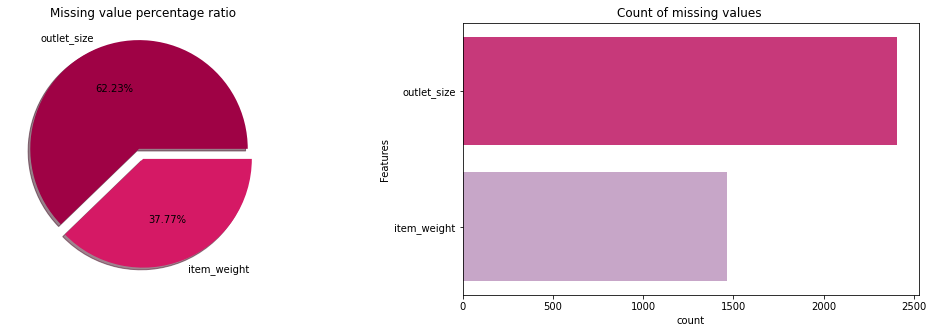

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.pie('Total',labels = top_5.index,data=top_5,
        autopct ='%.2f%%',
        colors =sns.color_palette('PuRd_r'),
        shadow=True,explode=(0.1,0.0))
plt.title('Missing value percentage ratio')

plt.subplot(1,2,2)
sns.barplot(top_5['Total'],y=top_5.index,palette = 'PuRd_r')
plt.xlabel('count')
plt.ylabel('Features')
plt.title('Count of missing values ');

#### There are several ways we can deal with these missing values
- 1. Dropping the column with missing value
- 2. Dropping rows containing missing value
- 3. we can impute with mean,median or mode(for categorical)
- 4. We can create a model to fill all these data

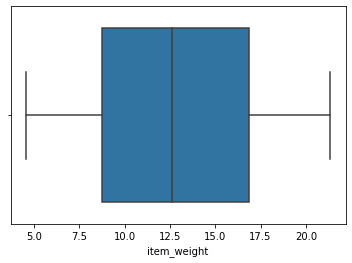

In [ ]:
sns.boxplot(df['item_weight'])

- since there are no outliers present we can impute the 0 values with the mean

In [ ]:
df['item_weight']=df['item_weight'].fillna(df['item_weight'].mean())

In [ ]:
print("we have",df.item_weight.isnull().sum(),"missing values in item_weight")

we have 0 missing values in item_weight


In [ ]:
print("we have",df.outlet_size.isnull().sum(),"missing values")
print("\n")
print(df['outlet_size'].value_counts())

we have 2410 missing values


Medium    2793
Small     2388
High       932
Name: outlet_size, dtype: int64


- as we can see above if we impute with the mode around 2410 it is not a good idea to impute with mode

      After imputing with the mode,bfill and ffill, and 'Small' for the missing values:
      - Mode gave the best results so we will keep that one

In [ ]:
df['outlet_size'] = df['outlet_size'].fillna(df['outlet_size'].mode().iloc[0])

In [ ]:
print("we have",df.isnull().sum().sum(),"missing values")

we have 0 missing values


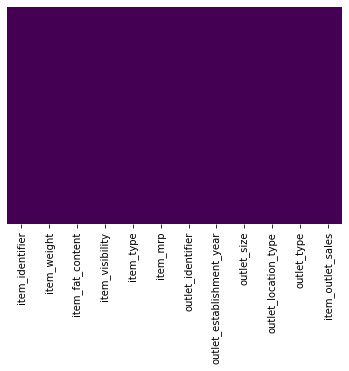

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### There is 0 present in item_visibility which does not make any sense since no item can have 0 visibilty,so we will replace 0 with the average visibility

In [ ]:
df['item_visibility']=df['item_visibility'].replace(0,df['item_visibility'].mean())

#### If we check the item identifer we have codes which specify what kind of an item it is, we will create a new feature for it

In [ ]:
df['new_item_type'] = df['item_identifier'].apply(lambda x: x[0:2])
df['new_item_type'] = df['new_item_type'].map({'FD':'Food',
                                               'NC':'Non-Consumable',
                                               'DR':'Drinks'})
df['new_item_type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: new_item_type, dtype: int64

#### let us create a new feature for outlet_establishment_year, we will subtract the years with 2013 since that was the year the data collection was done

In [ ]:
df['outlet_age'] = 2013- df['outlet_establishment_year']
bins = [0,10,20,100]
names = ['New outlet','Moderate outlet','old outlet']
df['outlet_age_category'] = pd.cut(df['outlet_age'],bins=bins,labels=names)

#### Let us change the shortcuts in item_fat_content

In [ ]:
df['item_fat_content'] = df['item_fat_content'].replace({'LF':'Low Fat',
                                                         'low fat':'Low Fat',
                                                         'reg':'Regular'})

In [ ]:
print(df.item_fat_content.unique())

['Low Fat' 'Regular']


#### However we also saw that  Non-Consumables also has Low fat in it for which we can assign a new value

In [ ]:
df.groupby(['item_fat_content','new_item_type']).size().reset_index()

,item_fat_content,new_item_type,0
0,Low Fat,Drinks,728
1,Low Fat,Food,3190
2,Low Fat,Non-Consumable,1599
3,Regular,Drinks,71
4,Regular,Food,2935


In [ ]:
df.loc[df['new_item_type']=="Non-Consumable",'item_fat_content'] = "Non-Edible"
df['item_fat_content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: item_fat_content, dtype: int64

#### Tranforming the right skewed data into normal distribution

      we can choose not to transform the right skewed data into normal distribution,however after finding the result both with skewness present and not present-
      Removing the skewnes gave us a better result

In [ ]:
def transform(feature):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  sns.histplot(data=df,x=feature,kde=True,color='blue')
  plt.title('Before transforming')

  plt.subplot(1,2,2)
  df[feature] = np.sqrt(df[feature])
  sns.histplot(data=df,x=feature,kde=True,color='purple')
  plt.title('After SQRT transformation')
  plt.show()

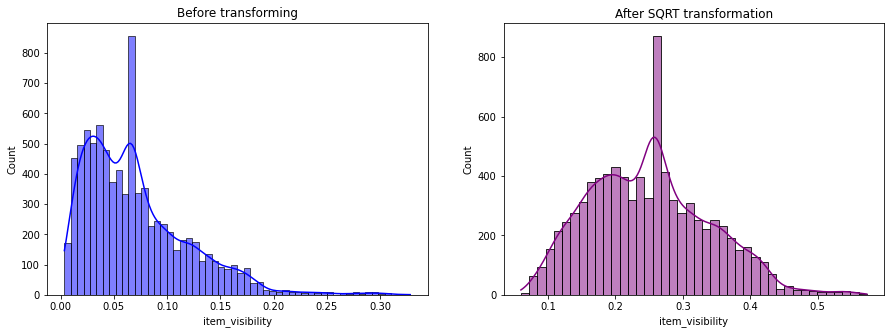

In [ ]:
transform('item_visibility')

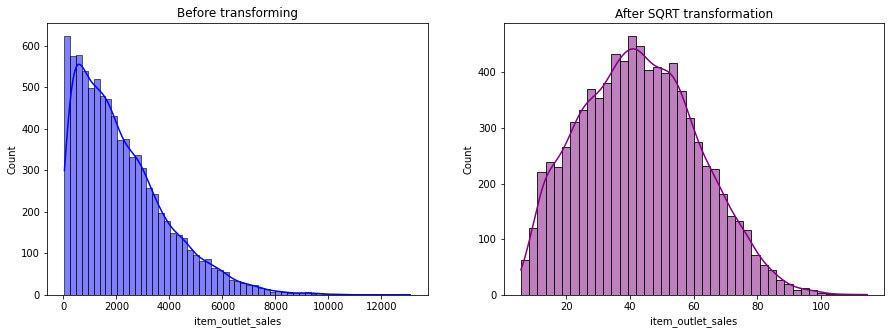

In [ ]:
transform('item_outlet_sales')

### Label Encoding

- Label encoding is done for those features which have some kind of an order to them.which can assign values to them manually or let the Sklearn- label encoder does it for us automatically
- in this case we will opt for the latter one

In [ ]:
df.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales', 'new_item_type', 'outlet_age',
       'outlet_age_category'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['outlet']  = le.fit_transform(df['outlet_identifier'])

df['item_fat_content'] = le.fit_transform(df['item_fat_content'])
df['outlet_size']  =le.fit_transform(df['outlet_size'])
df['outlet_location_type'] = le.fit_transform(df['outlet_location_type'])
df['new_item_type'] = le.fit_transform(df['new_item_type'])
df['outlet_type'] = le.fit_transform(df['outlet_type'])
df['outlet'] = le.fit_transform(df['outlet'])
df['outlet_age'] = le.fit_transform(df['outlet_age_category'])

In [ ]:
df.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales,new_item_type,outlet_age,outlet_age_category,outlet
0,FDA15,9.30,0,0.126678,Dairy,249.8092,OUT049,1999,1,0,1,61.115775,1,0,Moderate outlet,9
1,DRC01,5.92,2,0.138846,Soft Drinks,48.2692,OUT018,2009,1,2,2,21.057607,0,1,New outlet,3
2,FDN15,17.50,0,0.129461,Meat,141.6180,OUT049,1999,1,0,1,45.795961,1,0,Moderate outlet,9
3,FDX07,19.20,2,0.257161,Fruits and Vegetables,182.0950,OUT010,1998,1,2,0,27.062520,1,0,Moderate outlet,0
4,NCD19,8.93,1,0.257161,Household,53.8614,OUT013,1987,0,2,1,31.538947,2,2,old outlet,1


### One hot encoding

- In contrast to Label encoding one hot is done for the features which do not have an order
- one hot encoder assigns 1 when that particular value is present or else it will assign 0 which we can see below

In [ ]:
df = pd.get_dummies(df, columns = ['item_fat_content','outlet_size','outlet_location_type','new_item_type',
                                        'outlet_type','outlet','outlet_age'])

In [ ]:
df.head()

,item_identifier,item_weight,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,item_outlet_sales,outlet_age_category,item_fat_content_0,...,outlet_3,outlet_4,outlet_5,outlet_6,outlet_7,outlet_8,outlet_9,outlet_age_0,outlet_age_1,outlet_age_2
0,FDA15,9.30,0.126678,Dairy,249.8092,OUT049,1999,61.115775,Moderate outlet,1,...,0,0,0,0,0,0,1,1,0,0
1,DRC01,5.92,0.138846,Soft Drinks,48.2692,OUT018,2009,21.057607,New outlet,0,...,1,0,0,0,0,0,0,0,1,0
2,FDN15,17.50,0.129461,Meat,141.6180,OUT049,1999,45.795961,Moderate outlet,1,...,0,0,0,0,0,0,1,1,0,0
3,FDX07,19.20,0.257161,Fruits and Vegetables,182.0950,OUT010,1998,27.062520,Moderate outlet,0,...,0,0,0,0,0,0,0,1,0,0
4,NCD19,8.93,0.257161,Household,53.8614,OUT013,1987,31.538947,old outlet,0,...,0,0,0,0,0,0,0,0,0,1


- let us download a csv file for future work 

In [ ]:
df.to_csv('Big_mart_processed.csv',index=False)

- Let us drop all the features which will not be helpful for our analysis

In [ ]:
df.drop(['item_identifier','item_type','outlet_identifier','outlet_establishment_year','outlet_age_category'],axis=1,inplace=True)

### Model Building

In [ ]:
X = df.drop('item_outlet_sales',axis=1)
y = df['item_outlet_sales']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
def r2_mse_rmse(regressor_name,regressor,test_set,pred_set):
  print(regressor_name+'_accuracy:', round(regressor.score(X_train,y_train),3))
  
  print("r2_score is:",r2_score(test_set,pred_set))

  MSE = mean_squared_error(test_set,pred_set)
  print('we have an MSE of:',MSE)

  import math
  RMSE = math.sqrt(MSE)
  print('we have an RMSE of',RMSE)

In [ ]:
def pred_actual(regressor,pred_set):
  y_actual = y_test.to_numpy()
  result = np.concatenate((pred_set.reshape(len(pred_set),1),y_actual.reshape(len(y_actual),1)),1)
  result = pd.DataFrame(result,columns = ['predicted','actual'])
  print(result.head(10))

r2_Score:

    Without delving into detail r2_Score tells us how good our created model is,follow the link below for a better understanding
    https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/
Mean_sqaured_error:

    Again without delving deep MSE tells us how close our best fit line to the points,or what is the difference between the actual value and the predicted value
    Again if you want to know please google it
Root_mean_squared_error:

    RMSE tells us standard deviation of the residuals or simply it tells us how the data is spread out or concentrated around the best fit line

    

### 1.Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train,y_train)

LinearRegression()

In [ ]:
y_pred1 = regressor1.predict(X_test)

In [ ]:
pred_actual(regressor1,y_pred1)

   predicted     actual
0  47.235236  37.764316
1  45.674779  34.666540
2  44.248439  42.851796
3  46.490367  49.100527
4  53.664289  39.369816
5  59.236965  56.295719
6  50.035263  45.129616
7  40.976530  28.721529
8  24.874969  19.446707
9  40.126551  39.673054


In [ ]:
r2_mse_rmse('linear',regressor1,y_test,y_pred1)

linear_accuracy: 0.659
r2_score is: 0.6481826214590806
we have an MSE of: 122.12738567291935
we have an RMSE of 11.051125991179331


### 2 .XGBoost Regression

In [ ]:
from xgboost import XGBRegressor
regressor2 = XGBRegressor()
regressor2.fit(X_train, y_train)

[10:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
y_pred2 = regressor2.predict(X_test)

In [ ]:
pred_actual(regressor2,y_pred2)

   predicted     actual
0  49.427307  37.764316
1  41.478600  34.666540
2  46.393482  42.851796
3  46.650055  49.100527
4  50.169285  39.369816
5  60.952274  56.295719
6  49.807278  45.129616
7  42.016392  28.721529
8  20.933941  19.446707
9  42.580460  39.673054


In [ ]:
r2_mse_rmse('XgBoost',regressor2,y_test,y_pred2)

XgBoost_accuracy: 0.703
r2_score is: 0.6648502868830732
we have an MSE of: 116.34149069540226
we have an RMSE of 10.786171271373464


### 3 .RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor(n_estimators=100,max_depth=6, min_samples_leaf=50,n_jobs=4)
regressor3.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=50, n_jobs=4)

In [ ]:
y_pred3 = regressor2.predict(X_test)

In [ ]:
pred_actual(regressor3,y_pred3)

   predicted     actual
0  49.427307  37.764316
1  41.478600  34.666540
2  46.393482  42.851796
3  46.650055  49.100527
4  50.169285  39.369816
5  60.952274  56.295719
6  49.807278  45.129616
7  42.016392  28.721529
8  20.933941  19.446707
9  42.580460  39.673054


In [ ]:
r2_mse_rmse('RandomForest',regressor3,y_test,y_pred3)

RandomForest_accuracy: 0.688
r2_score is: 0.6648502868830732
we have an MSE of: 116.34149069540226
we have an RMSE of 10.786171271373464


### 4.Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
regressor4 = Lasso(alpha = 0.05)
regressor4.fit(X_train,y_train)

Lasso(alpha=0.05)

In [ ]:
y_pred4 = regressor4.predict(X_test)

In [ ]:
pred_actual(regressor4,y_pred4)

   predicted     actual
0  47.804753  37.764316
1  45.073445  34.666540
2  43.719996  42.851796
3  46.048177  49.100527
4  53.923482  39.369816
5  59.407362  56.295719
6  49.562387  45.129616
7  41.317935  28.721529
8  25.753444  19.446707
9  40.628259  39.673054


In [ ]:
r2_mse_rmse('Lasso',regressor4,y_test,y_pred4)

Lasso_accuracy: 0.658
r2_score is: 0.6477402133064285
we have an MSE of: 122.28096009641102
we have an RMSE of 11.058072169072284


### 5 .Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor5 = DecisionTreeRegressor(random_state=0)
regressor5.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred5 = regressor5.predict(X_test)

In [ ]:
pred_actual(regressor5,y_pred5)

   predicted     actual
0  43.606477  37.764316
1  34.231681  34.666540
2  50.524026  42.851796
3  37.922658  49.100527
4  34.095261  39.369816
5  56.543537  56.295719
6  48.616767  45.129616
7  44.122548  28.721529
8  24.191697  19.446707
9  36.032069  39.673054


In [ ]:
r2_mse_rmse('DecisionTree',regressor5,y_test,y_pred5)

DecisionTree_accuracy: 1.0
r2_score is: 0.29044993329975644
we have an MSE of: 246.30816990772243
we have an RMSE of 15.694208164406461


#### Conclusions:
- After trying with 5 linear models the best accuracy was from 
    - Xgboost
    - Random Forest
- In order to further increase the accuracy we need to get new features which actually impacts the outlet_sales.